In [31]:
import os
import librosa
import numpy as np
import csv
from sklearn.preprocessing import MinMaxScaler
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# MFCC parametreleri
n_mfcc = 40  # MFCC özelliği sayısı
frame_length = 25  # Milisaniye cinsinden frame uzunluğu
frame_stride = 10  # Milisaniye cinsinden frame kayması
max_duration = 3  # Maksimum ses süresi (saniye)

# Ses verisi arttırma işlemleri
def augment_audio(y, sr):
    augmenter = Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),   # Gürültü ekleme
        TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),  # Zaman kayması
        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),  # Ses tonu değişimi
    ])
    return augmenter(samples=y, sample_rate=sr)




# MFCC ve Chroma özelliklerini çıkarmak için fonksiyon
def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        # Ses uzunluğunu standartlaştırma
        y = librosa.util.fix_length(y, size=int(sr * max_duration))
        
        # Ses verisini arttır (data augmentation)
        y = augment_audio(y, sr)
        
        # MFCC
        hop_length = int(frame_stride * sr / 1000)
        n_fft = int(frame_length * sr / 1000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
        mfcc_mean = np.mean(mfcc, axis=1)
        
        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
        chroma_mean = np.mean(chroma, axis=1)
        
        # Tüm özellikleri birleştir
        features = np.concatenate([mfcc_mean, chroma_mean])
        return features
    except Exception as e:
        print(f"Dosya yükleme hatası: {file_path}, Hata: {e}")
        with open('error_log.txt', 'a') as error_file:
            error_file.write(f"{file_path}, Hata: {e}\n")
        return None

# Özellikleri çıkar ve CSV dosyasına kaydet
def extract_features_and_save_to_csv(directory, output_csv_file):
    features = []  # Özellikleri depolamak için liste
    labels = []    # Etiketleri depolamak için liste

    # Dosyaya yazmak için csv.writer
    with open(output_csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Başlık satırını ekle
        header = [f"MFCC_{i+1}" for i in range(n_mfcc)] + [f"Chroma_{i+1}" for i in range(12)] + ["Kişi", "Ses Türü"]
        writer.writerow(header)
        
        # Klasördeki her kişiyi (üst klasör) işleyelim
        for person in os.listdir(directory):
            person_path = os.path.join(directory, person)
            if os.path.isdir(person_path):  # Kişi klasörlerini kontrol et
                # Alt klasörleri (örneğin korku, mutlu) işleyelim
                for sub_folder in os.listdir(person_path):
                    sub_folder_path = os.path.join(person_path, sub_folder)
                    if os.path.isdir(sub_folder_path):  # Alt klasörleri kontrol et
                        for file in os.listdir(sub_folder_path):
                            if file.endswith('.wav'):
                                file_path = os.path.join(sub_folder_path, file)

                                # Özellikleri çıkar
                                features_data = extract_audio_features(file_path)
                                if features_data is not None:
                                    # Özellikleri kaydet
                                    writer.writerow(list(features_data) + [person, sub_folder])
                                    features.append(features_data)
                                    labels.append([person, sub_folder])

    # Özellikleri normalleştirme (0 ile 1 arasında)
    if features:
        scaler = MinMaxScaler()
        features_normalized = scaler.fit_transform(features)
        print(f"Özellikler 0-1 aralığına normalleştirildi. Boyut: {features_normalized.shape}")
    else:
        print("Hiç özellik çıkartılamadı.")
    print(f"Etiketler: {labels[:5]}")  # İlk 5 etiketi yazdır

# Klasör yolunu ve üst klasör yapısını belirtin
root_path = r'C:\VoiceProject\Voice'  # Ses dosyalarınızın bulunduğu ana klasör
output_csv_file = 'mfcc_chroma_features.csv'  # Özelliklerin kaydedileceği dosya

# Özellikleri çıkar ve CSV dosyasına kaydet
extract_features_and_save_to_csv(root_path, output_csv_file)

print(f"MFCC ve Chroma özellikleri '{output_csv_file}' dosyasına başarıyla kaydedildi.")


Özellikler 0-1 aralığına normalleştirildi. Boyut: (97, 52)
Etiketler: [['elif', 'korku'], ['elif', 'korku'], ['elif', 'korku'], ['elif', 'korku'], ['elif', 'korku']]
MFCC ve Chroma özellikleri 'mfcc_chroma_features.csv' dosyasına başarıyla kaydedildi.


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight, resample
import numpy as np

# CSV dosyasını yükle
csv_file = 'mfcc_chroma_features.csv'
data = pd.read_csv(csv_file)

# Özellikler ve etiketler
X = data.iloc[:, :-2].values  # Özellik sütunları (MFCC ve Chroma)
y = data.iloc[:, -2].values  # Kişi etiketleri

# Etiketleri sayısal formata dönüştür
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Etiketlerin dağılımını kontrol et
label_counts = pd.Series(y).value_counts()
print("Etiketlerin Dağılımı:")
print(label_counts)

# Sınıf ağırlıklarını hesaplama (dengesiz veri setleri için önerilir)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("\nSınıf Ağırlıkları:")
print(class_weights_dict)

# Özellikleri ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Eğitim ve test setlerini ayır (stratify=y_encoded ile dengeli veri bölmesi)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Eğitim setinde sınıf dağılımını kontrol et
train_class_counts = pd.Series(y_train).value_counts()
test_class_counts = pd.Series(y_test).value_counts()
print("\nEğitim Seti Sınıf Dağılımı:")
print(train_class_counts)
print("\nTest Seti Sınıf Dağılımı:")
print(test_class_counts)

# Eğitim ve test setlerinin boyutlarını yazdır
print(f"\nEğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# Veriyi dengesizse dengeleme (Upsampling)
# Eğitim setindeki azınlık sınıfları, çoğunluk sınıfına göre dengeleme
if len(train_class_counts) > 1:  # Sadece 2'den fazla sınıf varsa
    minority_class = train_class_counts.idxmin()  # Azınlık sınıfı
    minority_data = X_train[y_train == minority_class]
    minority_labels = y_train[y_train == minority_class]
    
    # Çoğunluk sınıfından aynı sayıda örnek alarak veri çoğaltma
    majority_class = train_class_counts.idxmax()
    majority_data = X_train[y_train == majority_class]
    majority_labels = y_train[y_train == majority_class]
    
    # Azınlık sınıfını çoğaltma
    minority_upsampled = resample(minority_data, minority_labels, 
                                  replace=True, 
                                  n_samples=majority_data.shape[0], 
                                  random_state=43)
    
    # Dengeleyerek tekrar birleştirme
    X_train_balanced = np.vstack([majority_data, minority_upsampled[0]])
    y_train_balanced = np.concatenate([majority_labels, minority_upsampled[1]])

    print("\nEğitim verisi dengelendi.")
else:
    X_train_balanced, y_train_balanced = X_train, y_train

# Eğitim ve test setlerinin dengelenmiş sınıf dağılımını kontrol et
balanced_train_class_counts = pd.Series(y_train_balanced).value_counts()
print("\nDengeleme Sonrası Eğitim Seti Sınıf Dağılımı:")
print(balanced_train_class_counts)

# K-Fold Cross-Validation (Stratified)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_balanced, y_train_balanced)):
    X_train_fold, X_val_fold = X_train_balanced[train_idx], X_train_balanced[val_idx]
    y_train_fold, y_val_fold = y_train_balanced[train_idx], y_train_balanced[val_idx]
    print(f"\nFold {fold+1} - Eğitim seti boyutu: {X_train_fold.shape}, Validasyon seti boyutu: {X_val_fold.shape}")


Etiketlerin Dağılımı:
elif     36
irem     31
nazli    30
Name: count, dtype: int64

Sınıf Ağırlıkları:
{0: 0.8981481481481481, 1: 1.043010752688172, 2: 1.0777777777777777}

Eğitim Seti Sınıf Dağılımı:
0    28
1    25
2    24
Name: count, dtype: int64

Test Seti Sınıf Dağılımı:
0    8
2    6
1    6
Name: count, dtype: int64

Eğitim seti boyutu: (77, 52)
Test seti boyutu: (20, 52)

Eğitim verisi dengelendi.

Dengeleme Sonrası Eğitim Seti Sınıf Dağılımı:
0    28
2    28
Name: count, dtype: int64

Fold 1 - Eğitim seti boyutu: (44, 52), Validasyon seti boyutu: (12, 52)

Fold 2 - Eğitim seti boyutu: (45, 52), Validasyon seti boyutu: (11, 52)

Fold 3 - Eğitim seti boyutu: (45, 52), Validasyon seti boyutu: (11, 52)

Fold 4 - Eğitim seti boyutu: (45, 52), Validasyon seti boyutu: (11, 52)

Fold 5 - Eğitim seti boyutu: (45, 52), Validasyon seti boyutu: (11, 52)


Fold 1 - Eğitim Seti F1 Skoru: 1.0000
Fold 1 - Validasyon Seti F1 Skoru: 0.8202


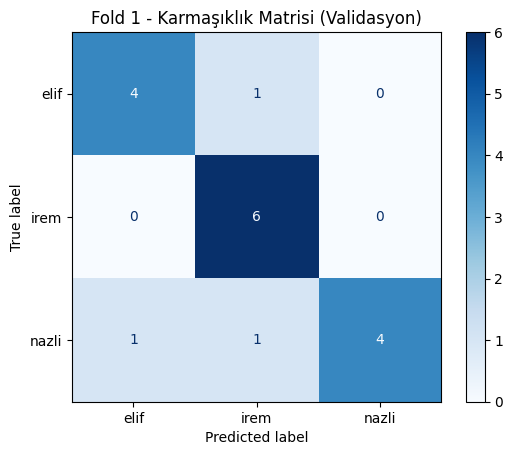

Fold 2 - Eğitim Seti F1 Skoru: 1.0000
Fold 2 - Validasyon Seti F1 Skoru: 0.7094


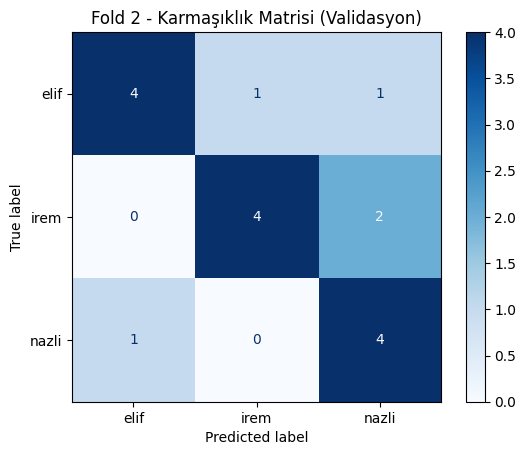

Fold 3 - Eğitim Seti F1 Skoru: 1.0000
Fold 3 - Validasyon Seti F1 Skoru: 0.7557


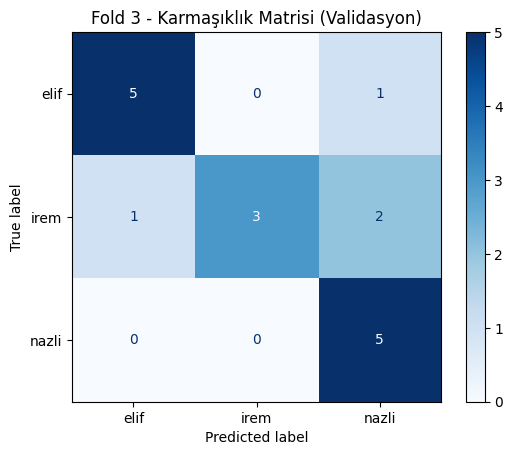

Fold 4 - Eğitim Seti F1 Skoru: 1.0000
Fold 4 - Validasyon Seti F1 Skoru: 0.7589


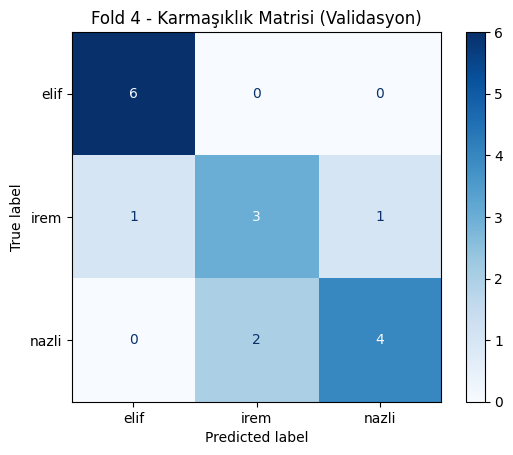

Fold 5 - Eğitim Seti F1 Skoru: 1.0000
Fold 5 - Validasyon Seti F1 Skoru: 0.7415


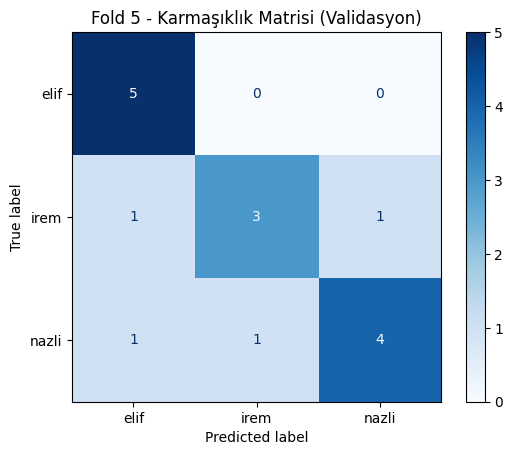


En iyi Fold: 1, Validasyon F1 Skoru: 0.8202

En iyi model kaydedildi.

Test Seti Doğruluk (Random Forest): 0.8000
Test Seti F1 Skoru (Random Forest): 0.8079


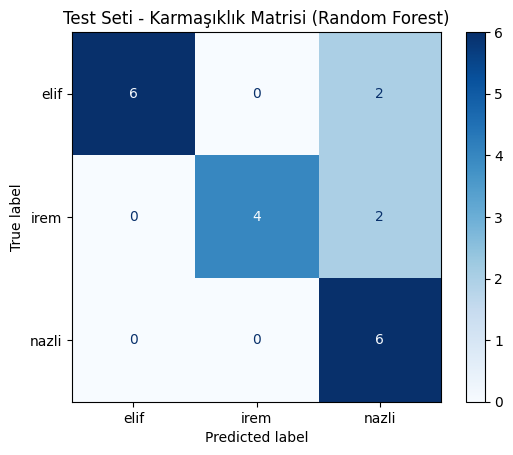

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

# Veriyi dengeleme işlemi (eğer gerekiyorsa)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Çapraz doğrulama için StratifiedKFold kullanıyoruz (eşit sınıf dağılımı sağlar)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modeli tanımlıyoruz
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Katman bazında sonuçları tutacağımız listeler
val_f1_scores = []
train_f1_scores = []

# Her bir katman için modelin eğitilmesi ve değerlendirilmesi
fold = 1
for train_index, val_index in kf.split(X_train_balanced, y_train_balanced):
    X_train_fold, X_val_fold = X_train_balanced[train_index], X_train_balanced[val_index]
    y_train_fold, y_val_fold = y_train_balanced[train_index], y_train_balanced[val_index]

    # Modeli eğitiyoruz
    rf_model.fit(X_train_fold, y_train_fold)

    # Eğitim ve validasyon setlerinde tahminler yapıyoruz
    y_train_pred = rf_model.predict(X_train_fold)
    y_val_pred = rf_model.predict(X_val_fold)

    # Eğitim seti sonuçları
    train_f1 = f1_score(y_train_fold, y_train_pred, average='weighted')
    
    # Validasyon seti sonuçları
    val_f1 = f1_score(y_val_fold, y_val_pred, average='weighted')

    # Katman sonuçlarını kaydediyoruz
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Fold {fold} - Eğitim Seti F1 Skoru: {train_f1:.4f}")
    print(f"Fold {fold} - Validasyon Seti F1 Skoru: {val_f1:.4f}")

    # Karmaşıklık matrisi (Validasyon seti)
    cm = confusion_matrix(y_val_fold, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Fold {fold} - Karmaşıklık Matrisi (Validasyon)')
    plt.show()

    fold += 1

# En iyi fold'u seçiyoruz (en yüksek validasyon F1 skorunu bulan fold)
best_fold = val_f1_scores.index(max(val_f1_scores)) + 1  # En iyi fold numarasını alıyoruz
print(f"\nEn iyi Fold: {best_fold}, Validasyon F1 Skoru: {max(val_f1_scores):.4f}")

# En iyi fold'daki modeli seçip kaydediyoruz
rf_model.fit(X_train_balanced, y_train_balanced)
joblib.dump(rf_model, 'best_rf_model.pkl')
print("\nEn iyi model kaydedildi.")

# Test seti ile değerlendirme
y_test_pred = rf_model.predict(X_test)

# Test seti doğruluğu ve F1 skoru
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"\nTest Seti Doğruluk (Random Forest): {test_accuracy:.4f}")
print(f"Test Seti F1 Skoru (Random Forest): {test_f1:.4f}")

# Test seti karmaşıklık matrisi
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
disp_test.plot(cmap='Blues')
plt.title('Test Seti - Karmaşıklık Matrisi (Random Forest)')
plt.show()


In [39]:
import joblib

# Eğitilmiş model ve diğer bileşenleri kaydetme
try:
    # Random Forest modelini kaydet
    joblib.dump(rf_model, 'best_rf_model.pkl')
    print("Random Forest modeli başarıyla kaydedildi!")

    # Etiket kodlayıcıyı kaydet
    joblib.dump(label_encoder, 'label_encoder.pkl')
    print("Etiket kodlayıcı başarıyla kaydedildi!")

    # Scaler'ı kaydet (eğer kullandıysanız)
    joblib.dump(scaler, 'scaler.pkl')
    print("Scaler başarıyla kaydedildi!")

except Exception as e:
    print(f"Kaydetme sırasında bir hata oluştu: {e}")


Random Forest modeli başarıyla kaydedildi!
Etiket kodlayıcı başarıyla kaydedildi!
Scaler başarıyla kaydedildi!


In [49]:
import sounddevice as sd
import librosa
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler

# Model ve diğer araçları yükle
try:
    clf = joblib.load('best_rf_model.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    scaler = joblib.load('scaler.pkl')  # Daha önce kullanılan scaler
    print("Model ve araçlar başarıyla yüklendi.")
except FileNotFoundError as e:
    print(f"Hata: Model veya araç dosyası bulunamadı: {e}")
    exit()
except Exception as e:
    print(f"Model veya araçlar yüklenirken bir hata oluştu: {e}")
    exit()

def record_audio(duration=3, sr=16000):
    """
    Mikrofon ile belirli bir süre ses kaydeder.
    duration: Kaydedilecek sesin süresi (saniye cinsinden)
    sr: Örnekleme oranı (Hz)
    """
    print("Konuşmaya başlayın...")
    try:
        audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
        sd.wait()  # Kaydın bitmesini bekle
        print("Kayıt tamamlandı!")
        return audio.flatten(), sr
    except Exception as e:
        print(f"Ses kaydı sırasında hata oluştu: {e}")
        return None, None

def extract_features_from_audio(audio, sr, n_mfcc=40):
    """
    Ses verisinden MFCC ve Chroma özelliklerini çıkarır.
    """
    try:
        # MFCC özellikleri
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        
        # Chroma özellikleri
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        
        # Tüm özellikleri birleştir
        features = np.concatenate([mfcc_mean, chroma_mean])
        return features
    except Exception as e:
        print(f"Özellik çıkarımı hatası: {e}")
        return None

def predict_from_microphone():
    # Ses kaydet
    audio, sr = record_audio(duration=3)
    if audio is None or sr is None:
        print("Ses kaydı yapılamadı.")
        return

    # Özellikleri çıkar
    features = extract_features_from_audio(audio, sr)
    if features is None:
        print("Tahmin yapılamadı. Özellikler çıkarılamadı.")
        return

    try:
        # Özellikleri 0 ile 1 arasına ölçeklendir (MinMaxScaler ile)
        features_scaled = scaler.transform([features])  # Daha önce kaydedilen scaler ile 0-1 aralığında ölçeklendirme
        
        # Tahmin yap
        predicted_label = clf.predict(features_scaled)
        
        # Etiketi çöz
        speaker_name = label_encoder.inverse_transform(predicted_label)
        
        # 3 kişiye de uymuyorsa "Tanımlanmadı" mesajı ver
        if speaker_name[0] in ['elif', 'irem', 'nazlı']:  # Örnek kişi isimleri
            print(f"Tahmin edilen konuşmacı: {speaker_name[0]}")
        else:
            print("Tanımlanmadı")
    except Exception as e:
        print(f"Tahmin yapılırken hata oluştu: {e}")

if __name__ == "__main__":
    predict_from_microphone()


Model ve araçlar başarıyla yüklendi.
Konuşmaya başlayın...
Kayıt tamamlandı!
Tahmin edilen konuşmacı: elif
